## Malicious Url Detection

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
from tld import get_tld
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [11]:
df = pd.read_csv('malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


<AxesSubplot:xlabel='type', ylabel='count'>

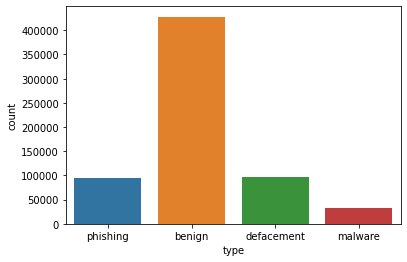

In [12]:
print(df.type.value_counts())
sns.countplot(x="type", data = df)

### Feature Engineering

Check if the url contain IP address (also in hexadecimal form)

0    643898
1      7293
Name: is_ip, dtype: int64


<AxesSubplot:xlabel='is_ip', ylabel='count'>

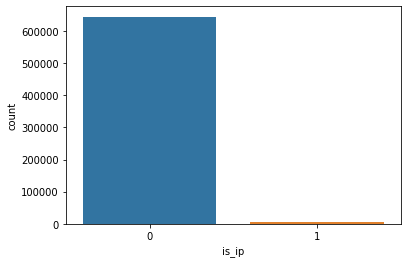

In [13]:
def have_ip_address(url):
  match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6

  return 1 if match else 0
  
df['is_ip'] = df['url'].apply(lambda i: have_ip_address(i))
print(df['is_ip'].value_counts())
sns.countplot(x = 'is_ip', data=df)


If url are able to parse by the parser make it normal(1) else abnormal url(0)

In [14]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)

    return 1 if match else 0

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

Calculate the lenght of all url

In [15]:
df['url_len'] = df['url'].apply(lambda x: len(str(x)))

Calculate the count of special character in url

In [16]:
features = ['@','?','-','=','.','#','%','+','$','!','*',',','www', "https", "http"]

for feature in features:
  df[feature] = df['url'].apply(lambda x: x.count(feature))

df.head()

,url,type,is_ip,abnormal_url,url_len,@,?,-,=,.,#,%,+,$,!,*,",",www,https,http
0,br-icloud.com.br,phishing,0,0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,88,0,1,1,4,3,0,0,0,0,0,0,0,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,235,0,1,1,3,2,0,0,0,0,0,0,0,0,0,1


Search for redirects, directories in urls paths

In [17]:
def no_of_redirects(url):
  parse_object = urlparse(url).path
  return str(parse_object).count('//')

def no_of_dir(url):
  parse_object = urlparse(url).path
  return str(parse_object).count('/')

df['redirects'] = df['url'].apply(lambda x: no_of_redirects(x))
df['dirs'] = df['url'].apply(lambda x: no_of_dir(x))

Search for the url shortening service in url

0    611436
1     39755
Name: short_url, dtype: int64


<AxesSubplot:xlabel='short_url', ylabel='count'>

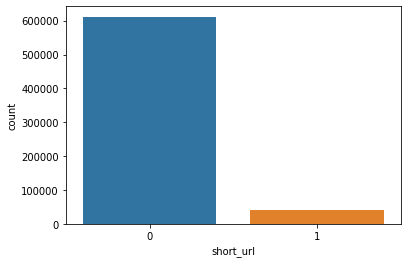

In [18]:
def sortening_service(url):
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
  return 1 if match else 0

df['short_url'] = df['url'].apply(lambda x: sortening_service(x))

print(df['short_url'].value_counts())
sns.countplot(x = 'short_url', data=df)

Extract features from Hostname

In [19]:
df['hostname_length'] = df['url'].apply(lambda x: len(urlparse(x).netloc))

Search for the supicious keywords such as payment, login, bank, etc. 

0    607818
1     43373
Name: suspicious, dtype: int64


<AxesSubplot:xlabel='suspicious', ylabel='count'>

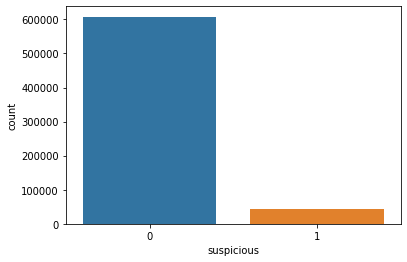

In [20]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    return 1 if match else 0

df['suspicious'] = df['url'].apply(lambda x: suspicious_words(x))

print(df['suspicious'].value_counts())
sns.countplot(x = 'suspicious', data=df)

Extract top level domain length

In [21]:
def get_tld_length(url):
  _tld = get_tld(url,fail_silently=True)

  if _tld:
    return int(len(str(_tld)))
  return 0

df['tld_length'] = df['url'].apply(lambda x: get_tld_length(x))

Count number of numerics and alphabates in the urls

In [22]:
def count_numbers(url):
  cnt = 0
  for ch in url:
    if ch.isdigit(): cnt+=1
  return cnt

def count_alpha(url):
  cnt = 0
  for ch in url:
    if ch.isalpha(): cnt+=1
  return cnt

df["count_digit"] = df['url'].apply(lambda x : count_numbers(x))
df["count_alpha"] = df['url'].apply(lambda x : count_alpha(x))

Visualizing the Correlation

<AxesSubplot:>

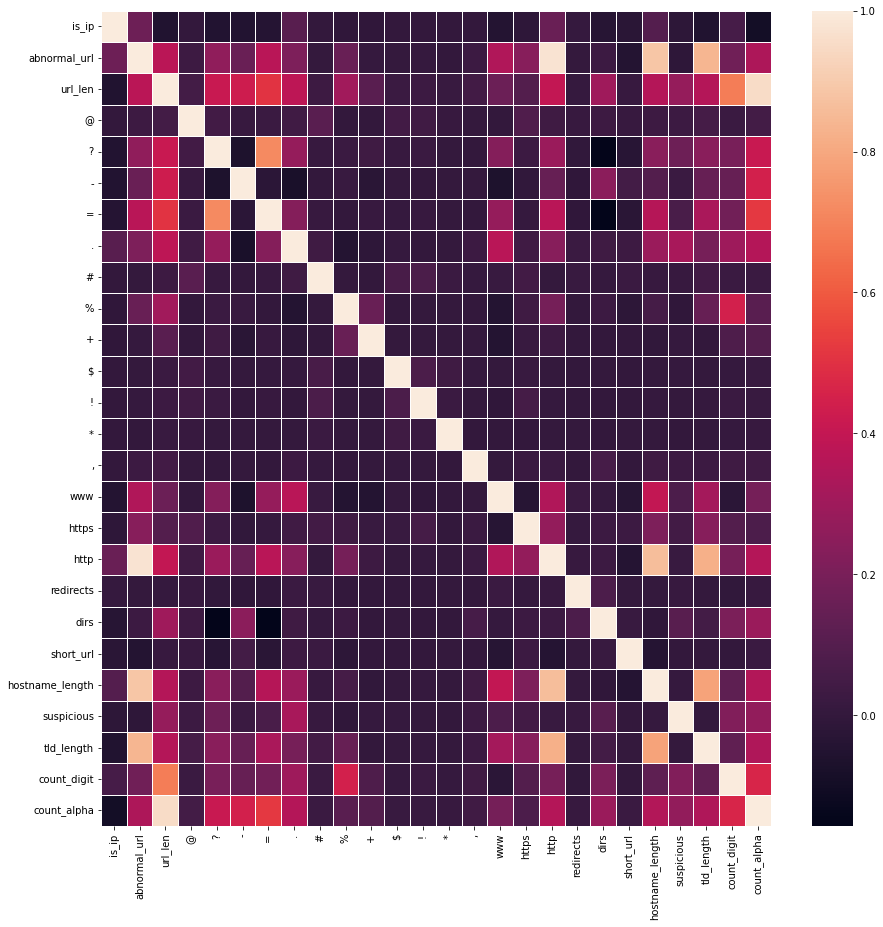

In [23]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), linewidths=.5)

### Preparing data for training


In [24]:
from sklearn.preprocessing import LabelEncoder

# lb_obj = LabelEncoder()
# df['label_type'] = lb_obj.fit_transform(df['type'])
# df['label_type'].value_counts()

def encode_label(url_type):
  if url_type == 'benign':
    return 0
  elif url_type == 'defacement':
    return 1
  elif url_type == 'phishing':
    return 2
  else:
    return 3

df['label_type'] = df['type'].apply(lambda x: encode_label(x))
df['label_type'].value_counts()

0    428103
1     96457
2     94111
3     32520
Name: label_type, dtype: int64

In [25]:
df.columns

Index(['url', 'type', 'is_ip', 'abnormal_url', 'url_len', '@', '?', '-', '=',
       '.', '#', '%', '+', '$', '!', '*', ',', 'www', 'https', 'http',
       'redirects', 'dirs', 'short_url', 'hostname_length', 'suspicious',
       'tld_length', 'count_digit', 'count_alpha', 'label_type'],
      dtype='object')

In [26]:
X = df.drop(['url', 'type', 'label_type'], axis = 1)
Y = df['label_type']

Spliting the data in Train and Test

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

Test Accuracy : 96.21618716359923%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85565
           1       0.98      0.99      0.98     19319
           2       0.90      0.84      0.87     18805
           3       0.98      0.94      0.96      6550

    accuracy                           0.96    130239
   macro avg       0.96      0.94      0.95    130239
weighted avg       0.96      0.96      0.96    130239

Confusion Matrix


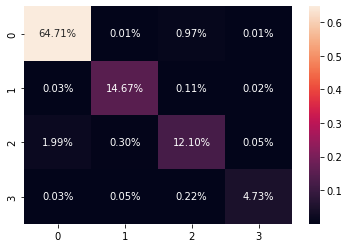

In [29]:
from sklearn.ensemble import RandomForestClassifier

model_randomForest = RandomForestClassifier()
model_randomForest.fit(X_train.values, Y_train.values)
pred = model_randomForest.predict(X_test.values)
acc = accuracy_score(pred,Y_test.values)

print(f'Test Accuracy : {acc*100}%')
print('Classification Report')
print(classification_report(Y_test, pred))
print('Confusion Matrix')
cf_matrix = confusion_matrix(Y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

Test Accuracy : 96.17702838627447%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85565
           1       0.98      0.99      0.98     19319
           2       0.90      0.83      0.87     18805
           3       0.99      0.94      0.96      6550

    accuracy                           0.96    130239
   macro avg       0.96      0.94      0.95    130239
weighted avg       0.96      0.96      0.96    130239

Confusion Matrix


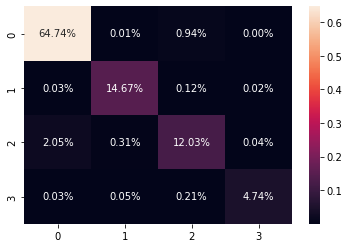

In [32]:
from sklearn.ensemble import ExtraTreesClassifier

model_ExtraTree = ExtraTreesClassifier()
model_ExtraTree.fit(X_train.values, Y_train.values)
pred = model_ExtraTree.predict(X_test.values)
acc = accuracy_score(pred,Y_test.values)

print(f'Test Accuracy : {acc*100}%')
print('Classification Report')
print(classification_report(Y_test.values, pred))
print('Confusion Matrix')
cf_matrix = confusion_matrix(Y_test.values, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

Test Accuracy : 79.66200600434586%
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     85565
           1       0.64      1.00      0.78     19319
           2       0.72      0.19      0.30     18805
           3       0.57      0.55      0.56      6550

    accuracy                           0.80    130239
   macro avg       0.70      0.66      0.63    130239
weighted avg       0.80      0.80      0.77    130239

Confusion Matrix


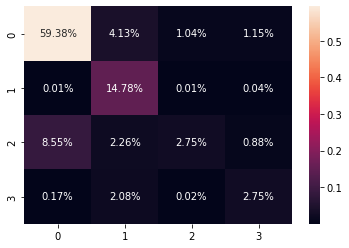

In [33]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()
model_GaussianNB.fit(X_train.values, Y_train.values)
pred = model_GaussianNB.predict(X_test.values)
acc = accuracy_score(pred,Y_test.values)

print(f'Test Accuracy : {acc*100}%')
print('Classification Report')
print(classification_report(Y_test.values, pred))
print('Confusion Matrix')
cf_matrix = confusion_matrix(Y_test.values, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

Test Accuracy : 95.59348582221915%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     85565
           1       0.97      0.98      0.98     19319
           2       0.88      0.82      0.85     18805
           3       0.96      0.94      0.95      6550

    accuracy                           0.96    130239
   macro avg       0.94      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

Confusion Matrix


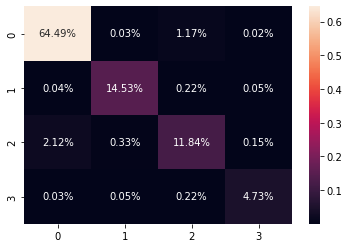

In [34]:
from sklearn.tree import DecisionTreeClassifier

model_DecisionTree = DecisionTreeClassifier()
model_DecisionTree.fit(X_train.values, Y_train.values)
pred = model_DecisionTree.predict(X_test.values)
acc = accuracy_score(pred,Y_test.values)

print(f'Test Accuracy : {acc*100}%')
print('Classification Report')
print(classification_report(Y_test, pred))
print('Confusion Matrix')
cf_matrix = confusion_matrix(Y_test, pred)
plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
plt.show()

### Converting the trained model into pickle file

In [ ]:
import pickle
pickle.dump(model_randomForest, open('malicious_url.pkl', 'wb'))

In [35]:
# import pickle
# pickle.dump(model_ExtraTree, open('malicious_url.pkl', 'wb'))

Loading the pickle file and predicting Testing data

In [ ]:
# pickle_model = pickle.load(open('malicious_url.pkl', 'rb'))
# pred = pickle_model.predict(X_test)
# acc = accuracy_score(pred,Y_test)

# print(f'Test Accuracy : {acc*100}%')
# print('Classification Report')
# print(classification_report(Y_test, pred))

Test Accuracy : 79.69195095171186%
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85565
           1       0.98      0.99      0.98     19319
           2       0.01      0.00      0.01     18805
           3       0.02      0.04      0.02      6550

    accuracy                           0.80    130239
   macro avg       0.49      0.51      0.50    130239
weighted avg       0.78      0.80      0.79    130239

